In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load new batch and concat with initial data
batch_1 = pd.read_csv('../../data/batch1_albayrak_labels.csv')
initial_molluscs_data = pd.read_csv('../../data/initial_molluscs_data.csv')
molluscs_df = pd.concat([initial_molluscs_data, batch_1])

molluscs_df

,Sex,Length,Width,Height,Weight,Non_Shell Weight,Intestine Weight,Shell Weight,Stage of Life
0,F,0.450000,0.345000,0.120000,0.416500,0.165500,0.095000,0.135000,Adult
1,F,0.475000,0.380000,0.145000,0.570000,0.167000,0.118000,0.187000,Adole
2,M,0.610000,0.485000,0.170000,1.022500,0.419000,0.240500,0.360000,Adult
3,I,0.430000,0.340000,0.105000,0.440500,0.238500,0.074500,0.107500,Adole
4,M,0.205000,0.155000,0.045000,0.042500,0.017000,0.005500,0.015500,Adult
...,...,...,...,...,...,...,...,...,...
245,M,0.710450,0.564696,0.128028,0.837041,0.626681,0.162846,0.453690,Adole
246,I,0.328120,0.264151,0.192703,0.290816,0.437779,0.140575,0.011481,Child
247,I,0.537831,0.501820,0.208908,1.011825,0.551533,0.396866,0.380240,Child
248,M,0.633878,0.263183,0.171297,0.737849,0.207348,0.189870,0.182853,Adult


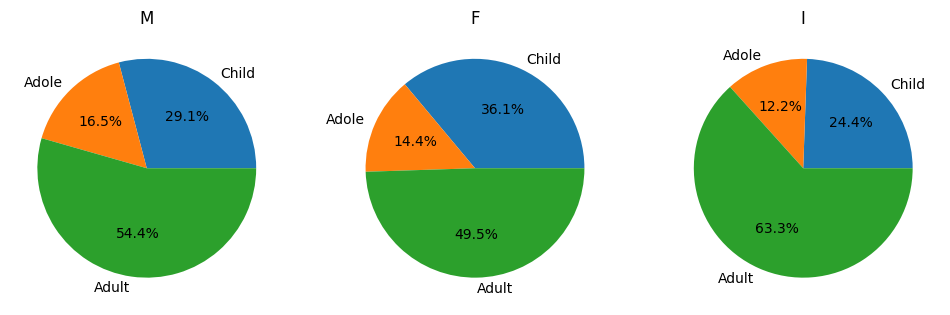

In [4]:
# Explore new data
life_stages = ['Child', 'Adole', 'Adult']
sexes = ['M', 'F', 'I']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for idx, s in enumerate(sexes):
    ratios = []
    for stage in life_stages:
        stage_ratio = len(molluscs_df[(molluscs_df['Stage of Life'] == stage) & (molluscs_df['Sex'] == s)])
        ratios.append(stage_ratio)

    # generate subplot for each sex
    axs[idx].pie(ratios, labels=life_stages, autopct='%1.1f%%')
    axs[idx].set_title(s)

fig.savefig('../../results/plots/stage_of_life_batch1.jpg')

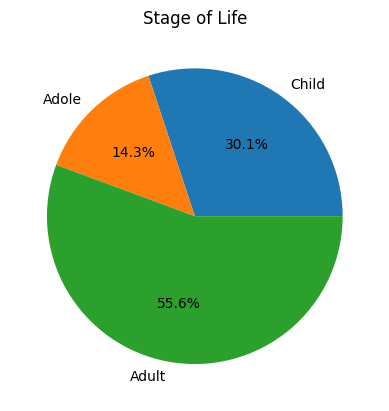

In [5]:
ratios = []
for stage in life_stages:
    ratio = len(molluscs_df[molluscs_df['Stage of Life']==stage])
    ratios.append(ratio)

plt.pie(ratios, labels=life_stages, autopct='%1.1f%%')
plt.title('Stage of Life')
plt.savefig('../../results/plots/batch1/stol.jpg')
plt.show()

mean and variance for Child: (0.5319738980712192, 0.14152284870888243)
mean and variance for Adole: (0.8779223694936547, 0.17472621563619367)
mean and variance for Adult: (1.144206210956719, 0.24167296604959715)


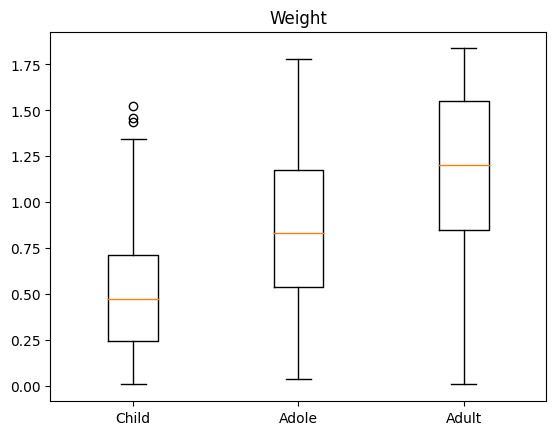

In [6]:
# Plot mean values for each sex
seq = []
feature = 'Weight'

mean_var_dict = {}

for s in life_stages:
    loc_df = molluscs_df[molluscs_df['Stage of Life'] == s]
    x = loc_df[feature]
    mean_var_dict[s] = (np.mean(x), np.var(x))
    print(f'mean and variance for {s}: {mean_var_dict[s]}')
    seq.append(x)

plt.boxplot(seq, labels=life_stages)
plt.title(feature)
plt.show()

In [7]:
# Compute optimal ratio of samples
n_samples = 266 + 250
optimal_ratio = n_samples/3
print(f'optimal ratio per class: {optimal_ratio}')

print('-----------------------')

for s in life_stages:
    loc_df = molluscs_df[molluscs_df['Stage of Life'] == s]
    print(f'current ratio {s}: {len(loc_df)}')
    print(f'needed samples: {optimal_ratio - len(loc_df)}')
    print('-----------------------')

optimal ratio per class: 172.0
-----------------------
current ratio Child: 80
needed samples: 92.0
-----------------------
current ratio Adole: 38
needed samples: 134.0
-----------------------
current ratio Adult: 148
needed samples: 24.0
-----------------------


In [8]:
from sklearn.preprocessing import LabelEncoder

# Convert nominal feature to numerical
lbl_encoder = LabelEncoder()
molluscs_df['Sex'] = lbl_encoder.fit_transform(molluscs_df['Sex'])

# Seperate X and y
X = molluscs_df.iloc[:, :8]
y = molluscs_df.iloc[:, 8]

In [9]:
from e2ml.preprocessing import StandardScaler

# Standardize each class seperately
scaler_child = StandardScaler()
scaler_adole = StandardScaler()
scaler_adult = StandardScaler()

child_df = X[y == 'Child']
scaler_child.fit(child_df)
child_df_std = scaler_child.transform(child_df)

adole_df = X[y == 'Adole']
scaler_adole.fit(adole_df)
adole_df_std = scaler_adole.transform(adole_df)

adult_df = X[y == 'Adult']
scaler_adult.fit(adult_df)
adult_df_std = scaler_adult.transform(adult_df)

# Child

In [10]:
from e2ml.experimentation import halton

n_samples_child = 150
bounds = [[-2, 2] for _ in range(8)]

# Generate 100 samples with latin hypercube
X_halton_child = halton(n_samples=n_samples_child, n_dimensions=8, bounds=bounds)

# Use random discrete values for nominal feature
X_halton_child[:, 0] = np.random.choice(np.unique(child_df_std[:, 0]), size=n_samples_child)

In [11]:
# Reconstruct design matrix
X_rec_child = scaler_child.inverse_transform(X_halton_child)

design_df_child = pd.DataFrame(data=X_rec_child, columns=X.columns)
design_df_child['Sex'] = design_df_child['Sex'].astype(int)

# Decode nominal features
design_df_child['Sex'] = lbl_encoder.inverse_transform(design_df_child['Sex'])


In [12]:
# Remove rows with values < 0
numerical_cols = ['Length', 'Width', 'Height', 'Weight', 'Non_Shell Weight', 'Intestine Weight', 'Shell Weight']
count = 0
for col in numerical_cols:
    design_df_child = design_df_child[design_df_child[col] >= 0]

design_df_child.shape

(102, 8)

In [13]:
# Drop 10 samples to obtain 92 samples
result_child = design_df_child.iloc[:92, :]

# Adole

In [14]:
from e2ml.experimentation import halton

n_samples_adole = 170
bounds = [[-2, 2] for _ in range(8)]

# Generate 100 samples with latin hypercube
X_halton_adole = halton(n_samples=n_samples_adole, n_dimensions=8, bounds=bounds)

# Use random discrete values for nominal feature
X_halton_adole[:, 0] = np.random.choice(np.unique(adole_df_std[:, 0]), size=n_samples_adole)

In [15]:
# Reconstruct design matrix
X_rec_adole = scaler_adole.inverse_transform(X_halton_adole)

design_df_adole = pd.DataFrame(data=X_rec_adole, columns=X.columns)
design_df_adole['Sex'] = design_df_adole['Sex'].astype(int)

# Decode nominal features
design_df_adole['Sex'] = lbl_encoder.inverse_transform(design_df_adole['Sex'])


In [16]:
# Remove rows with values < 0
numerical_cols = ['Length', 'Width', 'Height', 'Weight', 'Non_Shell Weight', 'Intestine Weight', 'Shell Weight']
count = 0
for col in numerical_cols:
    design_df_adole = design_df_adole[design_df_adole[col] >= 0]

design_df_adole.shape

(149, 8)

In [17]:
# Drop 10 samples to obtain 92 samples
result_adole = design_df_adole.iloc[:134, :]

# Adult

In [18]:
from e2ml.experimentation import halton

n_samples_adult = 50
bounds = [[-2, 2] for _ in range(8)]

# Generate 100 samples with latin hypercube
X_halton_adult = halton(n_samples=n_samples_adult, n_dimensions=8, bounds=bounds)

# Use random discrete values for nominal feature
X_halton_adult[:, 0] = np.random.choice(np.unique(adult_df_std[:, 0]), size=n_samples_adult)

In [19]:
# Reconstruct design matrix
X_rec_adult = scaler_adult.inverse_transform(X_halton_adult)

design_df_adult = pd.DataFrame(data=X_rec_adult, columns=X.columns)
design_df_adult['Sex'] = design_df_adult['Sex'].astype(int)

# Decode nominal features
design_df_adult['Sex'] = lbl_encoder.inverse_transform(design_df_adult['Sex'])


In [20]:
# Remove rows with values < 0
numerical_cols = ['Length', 'Width', 'Height', 'Weight', 'Non_Shell Weight', 'Intestine Weight', 'Shell Weight']
count = 0
for col in numerical_cols:
    design_df_adult = design_df_adult[design_df_adult[col] >= 0]

design_df_adult.shape

(38, 8)

In [21]:
# Drop 10 samples to obtain 92 samples
result_adult = design_df_adole.iloc[:24, :]

# Concat dataframes to a result

In [22]:
result_df = pd.concat([result_child, result_adole, result_adult])

In [23]:
feature = 'Shell Weight'

print(np.mean(molluscs_df[feature]))
print(np.mean(result_df[feature]))

result_df.to_csv('../../data/batch2_albayrak.csv', index=False)

0.26008979021509004
0.2579854230092994
